In [8]:
import mysql.connector

# Database Setup
- I copied the sql into a file sql_dump.txt and ran each line to setup the spam table

In [125]:
db = mysql.connector.connect(
        host="localhost",
        user="root",
        password="bromberg",
        database="predict_spam"
)

sql_dump = open('sql_dump.txt', 'r')
lines = sql_dump.readlines()
sql_dump.close()
for line in lines:
    cursor = db.cursor()
    cursor.execute(line)

# Determining List of Spammy Words
- I counted the frequencies of all the unique words for spam and ham messages
- I selected the top ten spammy words that appeared most frequently in spam messages that did not occur frequently in ham messages

In [164]:
from collections import defaultdict

spam_words = defaultdict(int)
ham_words = defaultdict(int)

sql = "select * from spam;"
cursor = db.cursor()
cursor.execute(sql)
output = cursor.fetchall()

for line in output:
    if line[0] == 'spam':
        for word in line[1].split(' '):
            spam_words[word] += 1
    if line[0] == 'ham':
        for word in line[1].split(' '):
            ham_words[word] += 1

sorted_spam = sorted(spam_words.items(), key=lambda item: item[1])[::-1]
sorted_ham = sorted(ham_words.items(), key=lambda item: item[1])[::-1]

print('Spam Words,  Ham Words')
for i in list(zip(sorted_spam, sorted_ham))[:60]:
    print(i)

Spam Words,  Ham Words
(('to', 606), ('to', 1531))
(('a', 358), ('you', 1485))
(('your', 187), ('I', 1444))
(('or', 185), ('the', 1021))
(('call', 185), ('a', 969))
(('the', 178), ('', 911))
(('for', 169), ('in', 738))
(('2', 169), ('and', 737))
(('you', 164), ('i', 736))
(('is', 145), ('u', 663))
(('Call', 136), ('is', 640))
(('on', 135), ('my', 618))
(('have', 128), ('me', 556))
(('and', 119), ('of', 500))
(('from', 116), ('for', 477))
(('ur', 107), ('that', 398))
(('with', 101), ('it', 388))
(('&', 98), ('your', 374))
(('of', 93), ('on', 353))
(('4', 93), ('have', 347))
(('FREE', 89), ('at', 336))
(('mobile', 83), ('not', 326))
(('are', 77), ('are', 319))
(('You', 77), ('be', 314))
(('our', 76), ('will', 291))
(('claim', 73), ('get', 286))
(('To', 73), ('2', 286))
(('Your', 71), ('can', 281))
(('U', 70), ("I'm", 278))
(('text', 69), ('but', 275))
(('txt', 68), ('so', 273))
(('in', 66), ('with', 250))
(('now', 64), ('U', 239))
(('Txt', 63), ('do', 237))
(('reply', 58), ('up', 231))
(

In [108]:
spammy_words = ['call', 'free', 'mobile', 'claim', 'reply', 'contact', 'stop', 'won', 'prize', 'cash']

# Compute Features Class
- this class is used to generate the features.csv file used to build the Weka decision tree diagram
- the class is initialized with a reference to the database connection, and a dataframe
- the class contains methods to compute the required features of each entry in the database
- the buildCsv method iterates through each entry in the spam database, computes the required features, and stores the results in features.csv

In [127]:
import pandas as pd
import re

class ComputeFeatures:
    def __init__(self, host="", username="", password="", database=""):
        self.db = mysql.connector.connect(host=host, user=username, password=password, database=database)
        self.df = pd.DataFrame()
    
    def doesHaveLinks(self, sms):
        regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        result = [x[0] for x in re.findall(regex, sms)]
        return len(result) > 0
    
    def doesHaveSpammyWords(self, sms):
        spammy_words = ['call', 'free', 'mobile', 'claim', 'reply', 'contact', 'stop', 'won', 'prize', 'cash']
        for word in spammy_words:
            if word in sms:
                return True
        return False
    
    def lengthOfText(self, sms):
        return len(sms)
    
    def buildCsv(self):
        class_label = []
        does_have_links = []
        does_have_spammy_words = []
        length_of_text = []
        
        sql = "select * from spam"
        cursor = db.cursor()
        cursor.execute(sql)
        output = cursor.fetchall()
        
        for line in output:
            classification = line[0]
            sms = line[1]
            class_label.append(classification)
            does_have_links.append(self.doesHaveLinks(sms))
            does_have_spammy_words.append(self.doesHaveSpammyWords(sms))
            length_of_text.append(self.lengthOfText(sms))
        self.df['Class Label'] = class_label
        self.df['doesHaveLinks'] = does_have_links
        self.df['doesHaveSpammyWords'] = does_have_spammy_words
        self.df['lengthOfText'] = length_of_text
        self.df.reset_index(drop=True)
        self.df.to_csv('features.csv', index=False)

### Instantiating the ComputeFeatures class and creating features.csv

In [128]:
cf = ComputeFeatures('localhost', 'root', 'bromberg', 'predict_spam')
cf.buildCsv()

# Weka Decision Tree
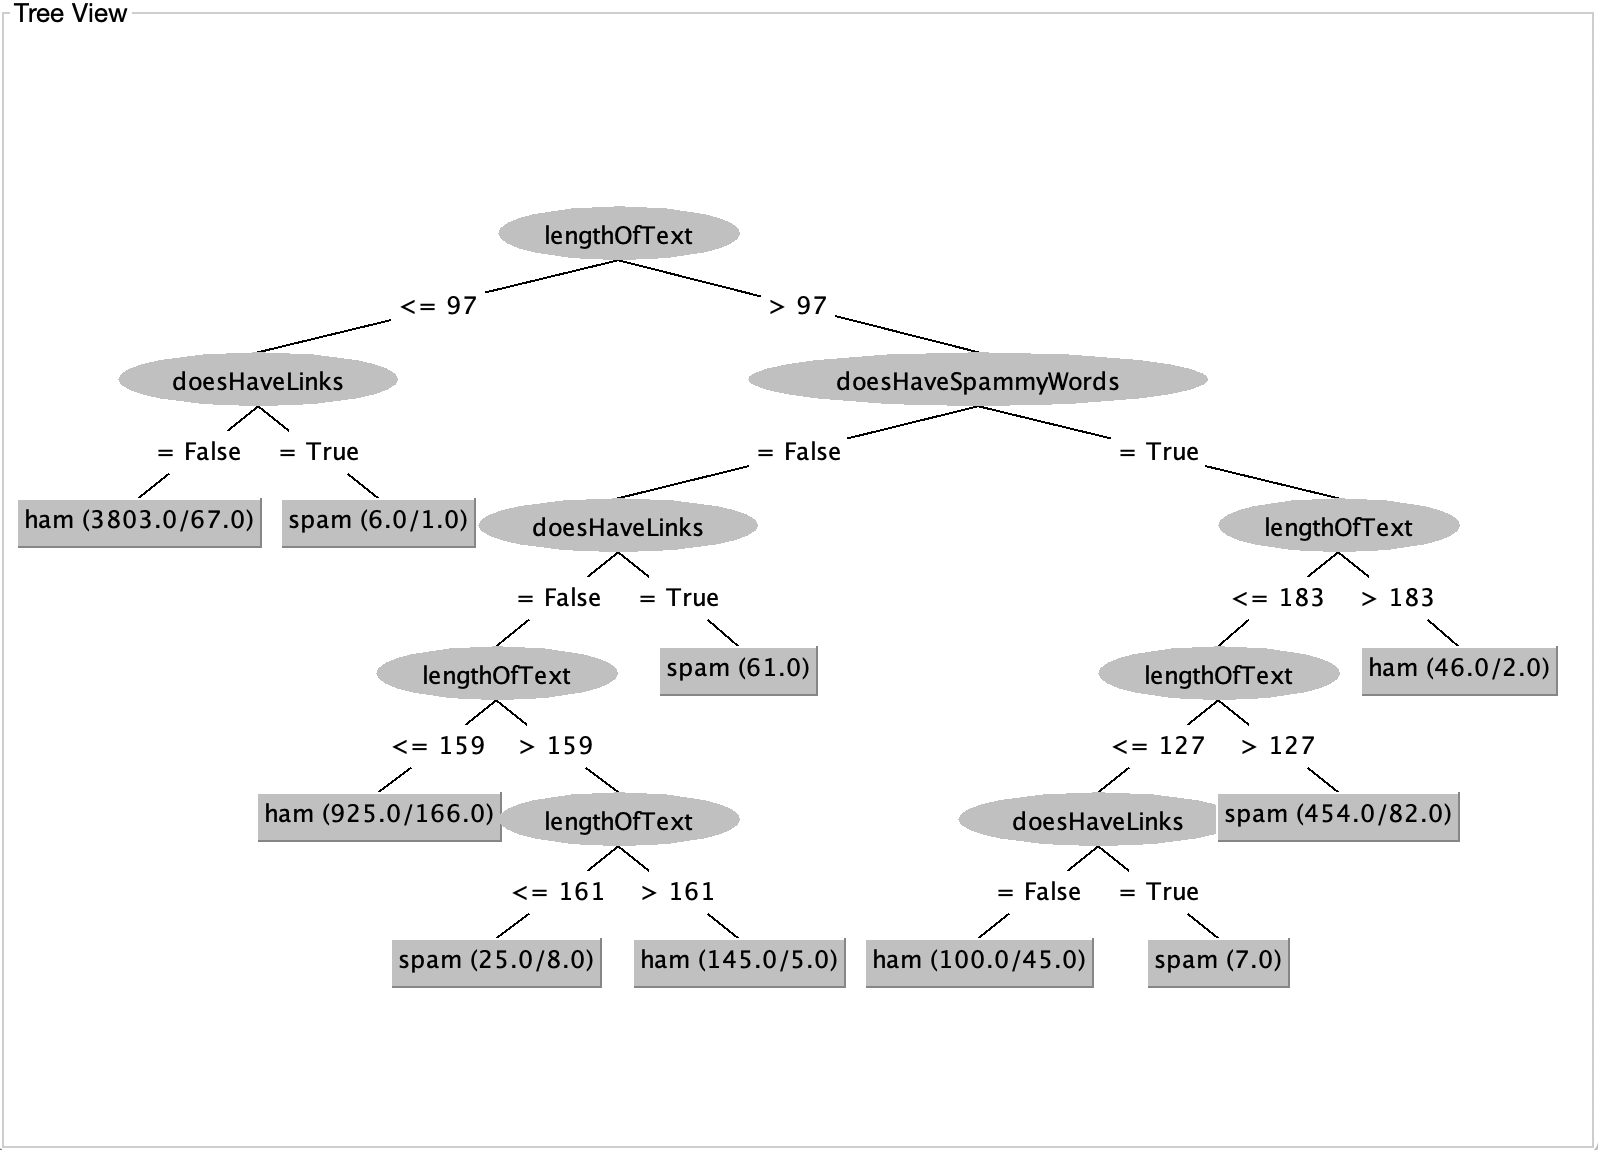

# Predict Spam Class

In [129]:
class predictSpam:
    def __init__(self, cf):
        self.cf = cf
    
    def makePrediction(self, sms):
        hasLinks = self.cf.doesHaveLinks(sms)
        hasSpammyWords = self.cf.doesHaveSpammyWords(sms)
        lengthOfText = self.cf.lengthOfText(sms)
        if lengthOfText > 97:
            if hasSpammyWords:
                if lengthOfText > 183:
                    return 'ham'
                else:
                    if lengthOfText > 127:
                        return 'spam'
                    else:
                        if hasLinks:
                            return 'spam'
                        else:
                            return 'ham'
            else:
                if hasLinks:
                    return 'spam'
                else:
                    if lengthOfText > 159:
                        if lengthOfText > 161:
                            return 'ham'
                        else:
                            return 'spam'
                    else:
                        return 'ham'
        else:
            if hasLinks:
                return 'spam'
            else:
                return 'ham'
            

# Testing the Predict Spam Class
- here I initialize a makePrediction object using the Compute Features object
- I then test the output of the makePrediction function with every entry in the database and compare the results to measure the accuracy of the prediction model


In [143]:
ps = predictSpam(cf)

sql = "select * from spam;"
cursor = db.cursor()
cursor.execute(sql)
output = cursor.fetchall()

correct = 0

for line in output:
    e = ps.makePrediction(line[1])
    a = line[0]
    if e == a:
        correct += 1

print('Accuracy of model on given database of 5572 messages: {}%'.format(round(correct/len(output), 2) * 100))

Accuracy of model on given database of 5572 messages: 93.0%


# Result
- After running all the entries in the database through the prediction model, I found that the model is about 93% accurate. This matches the results I saw in Weka.